# CoSQA dataset inspection

Looking for the first time in the data set, I decided to load it using pandas, data_loader didn't work for some reason when I tried. I was following the instructions on HuggingFace: https://huggingface.co/datasets/gonglinyuan/CoSQA 
I noticed that there are only trianing and validation (3% of all data) datasets. I decided to use validation dataset as test datasset for later fine tuning and to divide training dataset into train and val data (10% of initial training dataset).
Smaller then usual test and val datasets are chosen because in embedding-based systems, performance doesn’t fluctuate as violently with test size as in classification — because the task is to evaluate sets of queries with multiple candidates, not on independent samples.

In [1]:
import pandas as pd


df_test = pd.read_json("hf://datasets/gonglinyuan/CoSQA/cosqa-dev.json")
df_trainval = pd.read_json("hf://datasets/gonglinyuan/CoSQA/cosqa-train.json")

print(f"Train and validation size: {df_trainval.shape} | Test size: {df_test.shape}")

Train and validation size: (20000, 6) | Test size: (604, 6)


In [9]:
df_trainval.head(5)

,idx,doc,code,code_tokens,docstring_tokens,label
0,cosqa-train-0,python code to write bool value 1,"def writeBoolean(self, n):\n """"""\n ...","def writeBoolean ( self , n ) : t = TYPE_BOOL_...",Writes a Boolean to the stream .,0
1,cosqa-train-1,"""python how to manipulate clipboard""","def paste(xsel=False):\n """"""Returns system ...","def paste ( xsel = False ) : selection = ""prim...",Returns system clipboard contents .,0
2,cosqa-train-2,python colored output to html,"def _format_json(data, theme):\n """"""Pretty ...","def _format_json ( data , theme ) : output = j...",Pretty print a dict as a JSON with colors if p...,0
3,cosqa-train-3,"python ""create directory"" using ""relative path""","def create_path(path):\n """"""Creates a absol...",def create_path ( path ) : import os if not os...,Creates a absolute path in the file system .,0
4,cosqa-train-4,python column of an array,"def _vector_or_scalar(x, type='row'):\n """"""...","def _vector_or_scalar ( x , type = 'row' ) : i...",Convert an object to either a scalar or a row ...,0


In [2]:
df_trainval.nunique()

idx                 20000
doc                 20000
code                 6184
code_tokens          6184
docstring_tokens     6081
label                   2
dtype: int64

There is less code then doc unique values. So some code is repeated among some queries. Not handling this might affect results of this task

In [10]:
df = df_trainval
print(df['code'].duplicated().sum())
print(df['doc'].duplicated().sum())
print(df.isnull().sum())

13816
0
idx                 0
doc                 0
code                0
code_tokens         0
docstring_tokens    0
label               0
dtype: int64


There are not NaN values that need to be handled

In [ ]:
df['label'].value_counts(normalize=True)*100 # percentage of each label

label
0    51.465
1    48.535
Name: proportion, dtype: float64

Labels are pretty balanced. Following lines will show some more insights into the data.

In [17]:
df['doc_len'] = df['doc'].apply(len)
df['doc_len'].describe()

count    20000.000000
mean        37.122950
std         10.208856
min         16.000000
25%         30.000000
50%         35.000000
75%         43.000000
max         98.000000
Name: doc_len, dtype: float64

In [16]:
df['code_len'] = df['code'].apply(len)
df['code_len'].describe()

count    20000.000000
mean       276.340200
std        179.323344
min         87.000000
25%        184.000000
50%        236.000000
75%        322.000000
max       6395.000000
Name: code_len, dtype: float64

In [18]:
df.groupby('code')['doc'].nunique().sort_values(ascending=False).head(10)

code
def _check_whitespace(string):\n    """\n    Make sure thre is no whitespace in the given string. Will raise a\n    ValueError if whitespace is detected\n    """\n    if string.count(' ') + string.count('\t') + string.count('\n') > 0:\n        raise ValueError(INSTRUCTION_HAS_WHITESPACE)                                                                                                                                                               20
def _duplicates(list_):\n    """Return dict mapping item -> indices."""\n    item_indices = {}\n    for i, item in enumerate(list_):\n        try:\n            item_indices[item].append(i)\n        except KeyError:  # First time seen\n            item_indices[item] = [i]\n    return item_indices                                                                                                                                                       20
def most_significant_bit(lst: np.ndarray) -> int:\n    """\n    A helper function that finds th

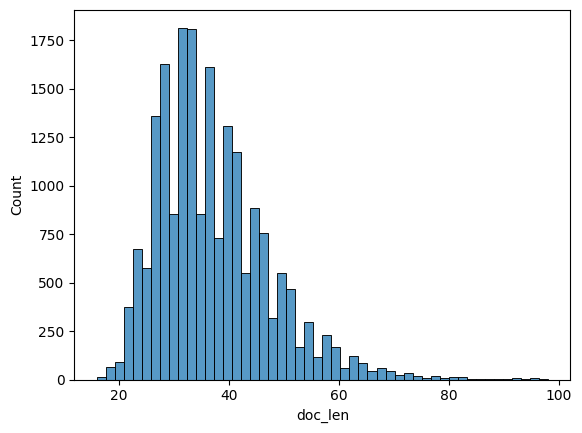

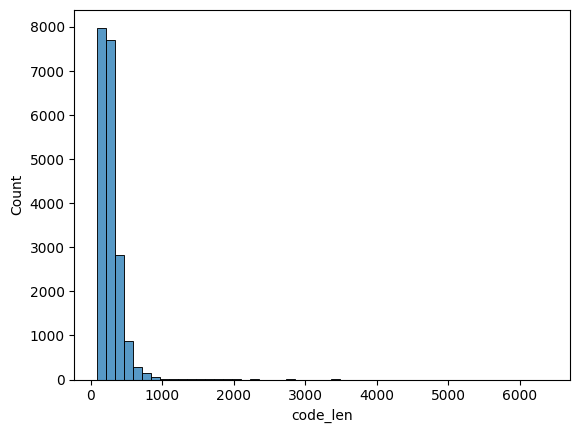

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['doc_len'], bins=50)
plt.show()

sns.histplot(df['code_len'], bins=50)
plt.show()

In [2]:
overlap = len(set(df_trainval['code']).intersection(set(df_test['code'])))
print("Code overlap:", overlap)

Code overlap: 469


In this task this is not considered as leakage since task is not a data generation but retrival. I needed to check since initial Recall@10 is unexpectedly high. Probably because, the CoSQA test set is designed as a **retrieval matching task** where:
- Each natural language query maps to ONE code snippet
- The model needs to find that single match among 552 options
- Generic embeddings already do well because the search space is small

In fine tuning goal should be to increase other metrics